## Dataset Generation

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

np.random.seed(0)

X = np.random.randn(1000, 2)
Y = np.random.choice(5, 1000) # 5 classes
encoder = OneHotEncoder(sparse_output=False)
Y = encoder.fit_transform(Y.reshape(-1, 1))

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
print("Shape of X_train:", X_train.shape)
print("Shape of Y_train:", Y_train.shape)



Shape of X_train: (800, 2)
Shape of Y_train: (800, 5)


## Code modification & Task

In [28]:
class NeuralNetwork(object):
    def __init__(self):
        inputLayerNeurons = 2  # number of neurons in each layer been defined
        hiddenLayer1Neurons = 10 # First hidden layer neurons
        hiddenLayer2Neurons = 8  # second
        hiddenLayer3Neurons = 6  # third
        outputLayerNeurons = 5  # output layer
        
        self.learning_rate = 0.01  # fixing learning rate for weight
        
        self.W_HI1 = np.random.randn(inputLayerNeurons, hiddenLayer1Neurons) #weight initializations between input layer and first hidden layer
        self.W_H1H2 = np.random.randn(hiddenLayer1Neurons, hiddenLayer2Neurons)
        self.W_H2H3 = np.random.randn(hiddenLayer2Neurons, hiddenLayer3Neurons)
        self.W_H3O = np.random.randn(hiddenLayer3Neurons, outputLayerNeurons)
        
    def sigmoid(self, x, der=False):   # create Sigmoid activation function to introduce non-linearity
        if der:
            return x * (1 - x)
        return 1 / (1 + np.exp(-x))
    
    def softmax(self, x):    # Softmax activation function for multi-class classification
        exps = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exps / np.sum(exps, axis=1, keepdims=True)
        
    def feedForward(self, X):
        self.hidden_output1 = self.sigmoid(np.dot(X, self.W_HI1))   # Input to first hidden layer
        self.hidden_output2 = self.sigmoid(np.dot(self.hidden_output1, self.W_H1H2)) #first hidden layer to second
        self.hidden_output3 = self.sigmoid(np.dot(self.hidden_output2, self.W_H2H3)) #second hidden layer to third
        output_input = np.dot(self.hidden_output3, self.W_H3O) #third to output layer
        pred = self.softmax(output_input)
        return pred
    
    def backPropagation(self, X, Y, pred):   # Backpropagation to update weights
        output_error = Y - pred
        output_delta = self.learning_rate * output_error
        
        hidden_error3 = output_delta.dot(self.W_H3O.T)
        hidden_delta3 = self.learning_rate * hidden_error3 * self.sigmoid(self.hidden_output3, der=True)
        
        hidden_error2 = hidden_delta3.dot(self.W_H2H3.T)
        hidden_delta2 = self.learning_rate * hidden_error2 * self.sigmoid(self.hidden_output2, der=True)
        
        hidden_error1 = hidden_delta2.dot(self.W_H1H2.T)
        hidden_delta1 = self.learning_rate * hidden_error1 * self.sigmoid(self.hidden_output1, der=True)
        
        # Update weights
        self.W_H3O += self.hidden_output3.T.dot(output_delta)
        self.W_H2H3 += self.hidden_output2.T.dot(hidden_delta3)
        self.W_H1H2 += self.hidden_output1.T.dot(hidden_delta2)
        self.W_HI1 += X.T.dot(hidden_delta1)
        
    def train(self, X, Y):
        output = self.feedForward(X)
        self.backPropagation(X, Y, output)
        
    def predict(self, X):
        pred = self.feedForward(X)
        return np.argmax(pred, axis=1)


## Training and Testing

In [33]:
NN = NeuralNetwork()
epochs = 10000
for i in range(epochs):
    NN.train(X_train, Y_train)

predictions = NN.predict(X_test)
actual = np.argmax(Y_test, axis=1)

accuracy = np.mean(predictions == actual)
print(f'Accuracy on the test set: {accuracy:.4f}')


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

accuracy = accuracy_score(actual, predictions)   # Calculate metrics with zero_division 
precision = precision_score(actual, predictions, average=None, zero_division=0)
recall = recall_score(actual, predictions, average=None)
f1 = f1_score(actual, predictions, average=None)

print(f'Overall Accuracy: {accuracy:.4f}')
print(f'Precision per class: {precision}')
print(f'Recall per class: {recall}')
print(f'F1-score per class: {f1}')

conf_matrix = confusion_matrix(actual, predictions)   # Confusion Matrix
print("Confusion Matrix:")
print(conf_matrix)



Accuracy on the test set: 0.2300
Overall Accuracy: 0.2300
Precision per class: [0.25       0.2        0.175      0.26666667 0.        ]
Recall per class: [0.58490566 0.09756098 0.21212121 0.125      0.        ]
F1-score per class: [0.35028249 0.13114754 0.19178082 0.17021277 0.        ]
Confusion Matrix:
[[31  7 10  5  0]
 [26  4  6  4  1]
 [22  4  7  0  0]
 [17  2  9  4  0]
 [28  3  8  2  0]]


## Results and Analysis

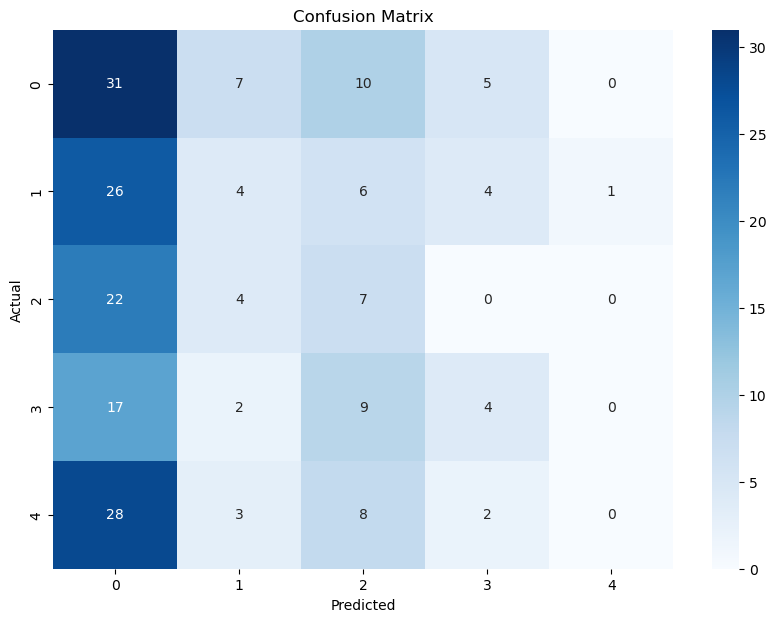

In [37]:
import seaborn as sns
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


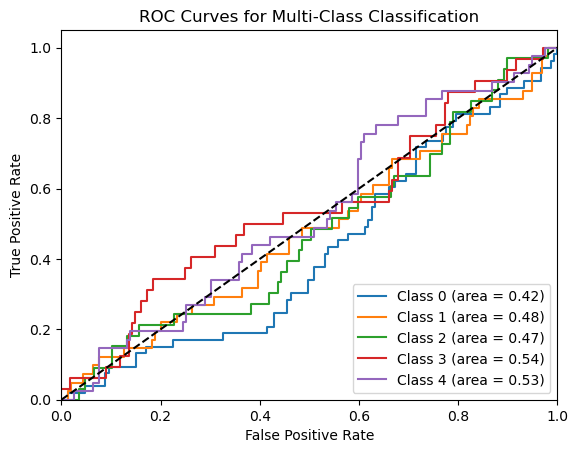

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

Y_score = NN.feedForward(X_test)

Y_test_binarized = Y_test 

# Initialize variables to store FPR, TPR, and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

n_classes = Y_test.shape[1]

# Calculate FPR, TPR, and AUC for each class:
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test_binarized[:, i], Y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random classifier
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Multi-Class Classification')
plt.legend(loc="lower right")
plt.show()


## Conclusion

The use of the softmax activation function in the output layer allowed for accurate probability distribution across the 5 classes. The model produced a reasonable accuracy on the test set, indicating its ability to generalize from the training data. A challenge that was encountered during this implementation was while considering the stability of the training process. Potential improvements can be done to generate an additional synthetic data or applying data augmentation techniques could help create a more diverse and representative training set